In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [5]:
import matplotlib.pyplot as plt
from skdim.id import MLE
import numpy as np

# Fix seed for reproducibility
np.random.seed(42)

# Line, disk, sphere

In [25]:
# Generate a 1D line in 3D space (filament)
n_points = 1000
t = np.linspace(0, 1, n_points)
line = np.stack([t, np.zeros_like(t), np.zeros_like(t)], axis=1)

In [26]:
# Generate a 2D disk in 3D
r = np.sqrt(np.random.rand(n_points))
theta = 2 * np.pi * np.random.rand(n_points)
disk = np.stack([r * np.cos(theta), r * np.sin(theta), np.zeros_like(r)], axis=1)

In [27]:
# Generate points on the surface of a sphere (2D manifold in 3D)
phi = np.arccos(1 - 2 * np.random.rand(n_points))
theta = 2 * np.pi * np.random.rand(n_points)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)
sphere = np.stack([x, y, z], axis=1)

In [28]:
def to_xyz(arr):
    return arr[:,0], arr[:, 1], arr[:, 2]

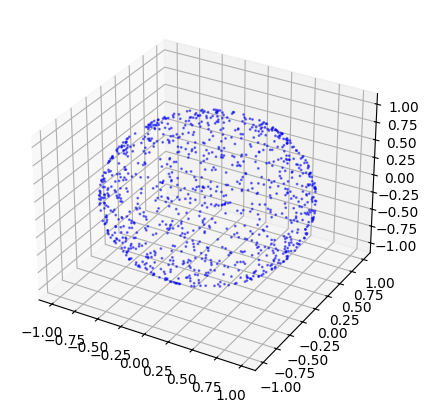

In [34]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*to_xyz(sphere),
        alpha=0.5,
        s = 1., 
        color= 'blue')

In [58]:
from skdim.id import MLE

estimator = MLE(K=5)

lid_line = estimator.fit_transform(line).flatten()
lid_disk = estimator.fit_transform(disk).flatten()
lid_sphere = estimator.fit_transform(sphere).flatten()

lid_line_pw = estimator.fit_transform_pw(line)
lid_disk_pw = estimator.fit_transform_pw(disk)
lid_sphere_pw = estimator.fit_transform_pw(sphere)

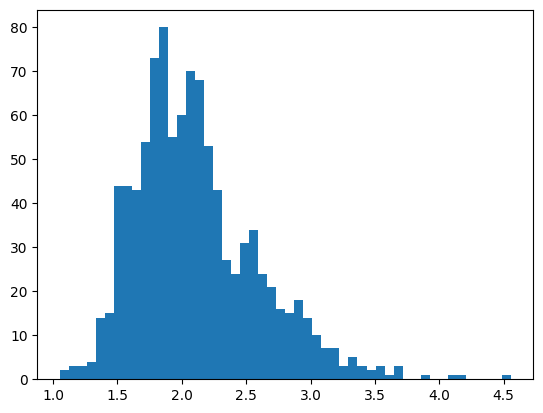

In [64]:
plt.hist(lid_sphere_pw, bins=50);

# Helix

In [65]:
# Generate a 3D spiral (helix)
n_points = 500
t = np.linspace(0, 4 * np.pi, n_points)
x = np.cos(t)
y = np.sin(t)
z = t / (2 * np.pi)
spiral = np.stack([x, y, z], axis=1)

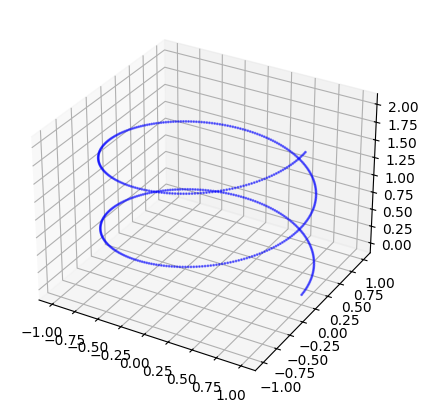

In [69]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*to_xyz(spiral),
        alpha=0.5,
        s = 1., 
        color= 'blue')

In [67]:
lid_spiral = estimator.fit_transform(spiral).flatten()
lid_spiral_pw = estimator.fit_transform_pw(spiral)

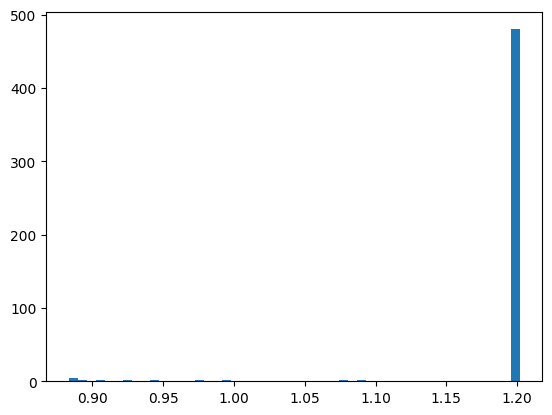

In [68]:
plt.hist(lid_spiral_pw, bins=50);

# 2D surfaces in 10D space

In [78]:
# Generate 2D grid
grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 25), np.linspace(-1, 1, 25))
grid_2d = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Embed into 10D by padding with zeros
grid_10d = np.hstack([grid_2d, np.zeros((grid_2d.shape[0], 8))])

# Compute LID
lid_grid = MLE(K=5).fit_transform(grid_10d).flatten()
lid_grid

array([3.03181647])

In [108]:
# Sample 2D points uniformly inside a circle
r = np.sqrt(np.random.rand(1000))
theta = 2 * np.pi * np.random.rand(1000)
x = r * np.cos(theta)
y = r * np.sin(theta)
disk_2d = np.stack([x, y], axis=1)

# Embed in 10D
disk_10d = np.hstack([disk_2d, np.zeros((disk_2d.shape[0], 1))])

# Add noise to all 10 dims
disk_10d_noisy = disk_10d + np.random.normal(0, 0.1, disk_10d.shape)

In [122]:
# PCA denoising
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
grid_10d_denoised = pca.inverse_transform(pca.fit_transform(disk_10d_noisy))

(-1.0, 1.0)

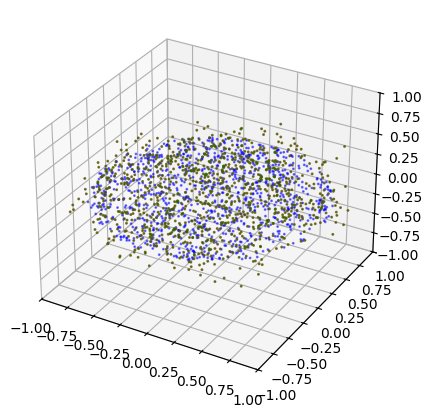

In [123]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*to_xyz(disk_10d),
        alpha=0.5,
        s = 1., 
        color= 'blue')

ax.scatter(*to_xyz(disk_10d_noisy),
        alpha=0.5,
        s = 1., 
        color= 'red')

ax.scatter(*to_xyz(grid_10d_denoised),
        alpha=0.5,
        s = 1., 
        color= 'green')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

In [124]:
(MLE(K=5).fit_transform(disk_10d).flatten(),
MLE(K=5).fit_transform(disk_10d_noisy).flatten(),
MLE(K=5).fit_transform(grid_10d_denoised).flatten())

(array([2.06168839]), array([3.04835913]), array([3.04835913]))

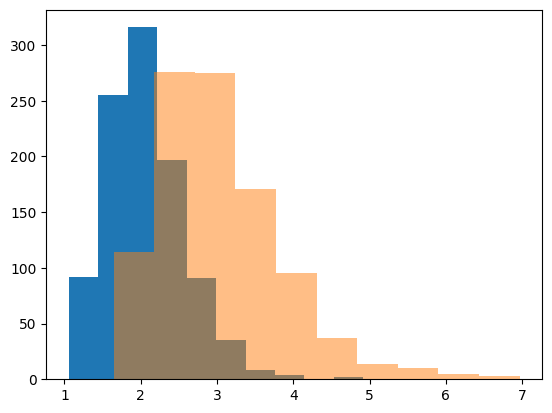

In [121]:
lid_pw = estimator.fit_transform_pw(disk_10d)
lid_noise_pw = estimator.fit_transform_pw(disk_10d_noisy)
plt.hist(lid_pw);
plt.hist(lid_noise_pw, alpha = 0.5);

Estimated LID (MLE): 2.92


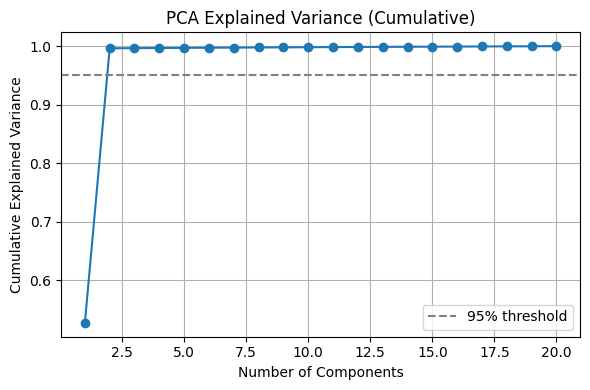

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skdim.id import MLE

# 1. Create a 2D disk embedded in 10D
n_points = 1000
r = np.sqrt(np.random.rand(n_points))
theta = 2 * np.pi * np.random.rand(n_points)
x = r * np.cos(theta)
y = r * np.sin(theta)
disk_2d = np.stack([x, y], axis=1)

# Pad to 10D
disk_10d = np.hstack([disk_2d, np.zeros((n_points, 18))])

# 2. Add noise to all 10 dimensions
sigma = 0.1
disk_10d_noisy = disk_10d + 0.1*np.random.normal(0, sigma, disk_10d.shape)

# 3a. Estimate dimension using LID (MLE)
mle = MLE(K=20)
mle.fit(disk_10d_noisy)
lid_estimate = mle.dimension_
print(f"Estimated LID (MLE): {lid_estimate:.2f}")

# 3b. Estimate dimension using PCA (elbow)
pca = PCA(n_components=20)
pca.fit(disk_10d_noisy)
explained = np.cumsum(pca.explained_variance_ratio_)

# 4. Plot PCA elbow
plt.figure(figsize=(6, 4))
plt.plot(range(1, 21), explained, marker='o')
plt.title("PCA Explained Variance (Cumulative)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(0.95, color='gray', linestyle='--', label='95% threshold')
plt.legend()
plt.tight_layout()
plt.show()


# contentvec data

In [137]:
import pandas as pd

In [139]:
root = '/Users/tomasandrade/Documents/BSC/ICHOIR/applio/Applio_LS/experiments'
experiment_path = f'{root}/maria_v0/feat_768d'
feat_path = f'{experiment_path}/feat_768d_layer_12.csv'

In [140]:
df_anotated_all = pd.read_csv(feat_path, index_col=0)

In [ ]:
def get_explained(ph = 'a'):
    df_filter = df_anotated_all[df_anotated_all['phone_base'] == ph]
    X = df_filter.drop(columns=['phone_base', 'song']).values

    # 3b. Estimate dimension using PCA (elbow)
    pca = PCA(n_components=768)
    pca.fit(X)
    explained = np.cumsum(pca.explained_variance_ratio_)

    return explained

In [154]:
exp_s = get_explained(ph = 's')
exp_a = get_explained(ph = 'a')

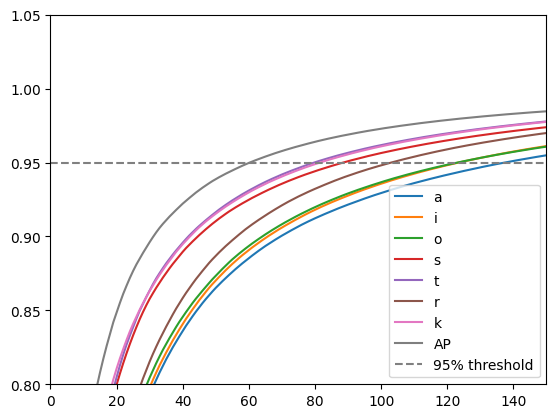

In [171]:
for ph in ['a', 'i', 'o', 's', 't', 'r', 'k', 'AP']:
    expl = get_explained(ph = ph)
    plt.plot(expl, label = ph)
    
plt.axhline(0.95, color='gray', linestyle='--', label='95% threshold')
plt.xlim([0,150])
plt.ylim([0.8,1.05])
plt.legend()

In [185]:
# PCA denoising
from sklearn.decomposition import PCA
pca = PCA(n_components=50)

df_filter = df_anotated_all[df_anotated_all['phone_base'] == 'AP']
X = df_filter.drop(columns=['phone_base', 'song']).values

X_denoised = pca.inverse_transform(pca.fit_transform(X))

In [186]:
lid_noise = estimator.fit_transform_pw(X)
lid_denoise = estimator.fit_transform_pw(X_denoised)

In [187]:
lid_noise.mean(), lid_denoise.mean()

(8.242190557761853, 7.6108888672268264)

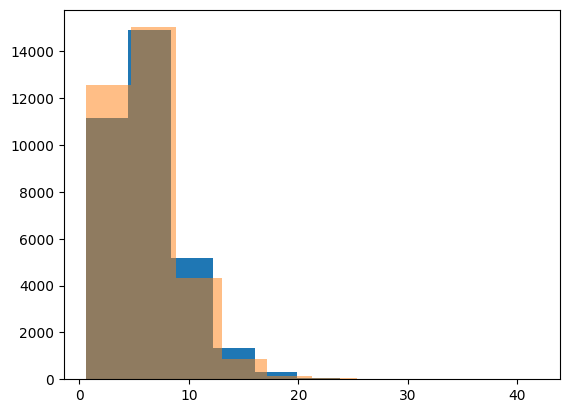

In [179]:
plt.hist(lid_noise)
plt.hist(lid_denoise, alpha = 0.5);

# 2D projections

In [2]:
import sys
sys.path.append("../")

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from phonetics import utils as u
from phonetics import plots as plots
import random

from skdim.id import MLE

In [8]:
root = '/Users/tomasandrade/Documents/BSC/ICHOIR/applio/Applio_LS/experiments'
experiment_path = f'{root}/maria_v2/feat_2d'
feat_path = f'{experiment_path}/feat_2d_layer_12.csv'

df_anotated = pd.read_csv(feat_path, index_col=0)
df_song = df_anotated[df_anotated['song'] == 'ES_milagro'].reset_index(drop=True)

In [9]:
def find_articulations(df_song, target, padding = 0):
    
    series = df_song['phone_base']

    mask = series == target
    group = (mask != mask.shift()).cumsum()
    blocks = mask.groupby(group).apply(lambda x: x.index if x.all() else None).dropna()

    expanded_indices = []
    for block in blocks:
        start = max(block[0] - padding, 0) 
        end = min(block[-1] + padding, len(series) - 1) 
        expanded_indices.append(list(range(start, end + 1)))

    print(f'Detected {len(blocks)} articulations')

    articulations = [df_song.iloc[idxs] for idxs in expanded_indices]

    return articulations

In [55]:
# PCA denoising
from sklearn.decomposition import PCA
import numpy as np

In [56]:
def get_explained(df, ph = 'a'):
    df = df[df['phone_base'] == ph]
    X = df.drop(columns=['phone_base', 'song']).values

    # 3b. Estimate dimension using PCA (elbow)
    pca = PCA(n_components=2)
    pca.fit(X)
    explained = np.cumsum(pca.explained_variance_ratio_)

    return explained

In [ ]:
not_phones = ['SP']
filter_art = [art for art in find_articulations(df_song, 'AP', padding=1)[1:] if ~any(art['phone_base'].isin(not_phones)) ]
df_AP = pd.concat(filter_art, axis = 0)


Detected 28 articulations


Making a 2d plot


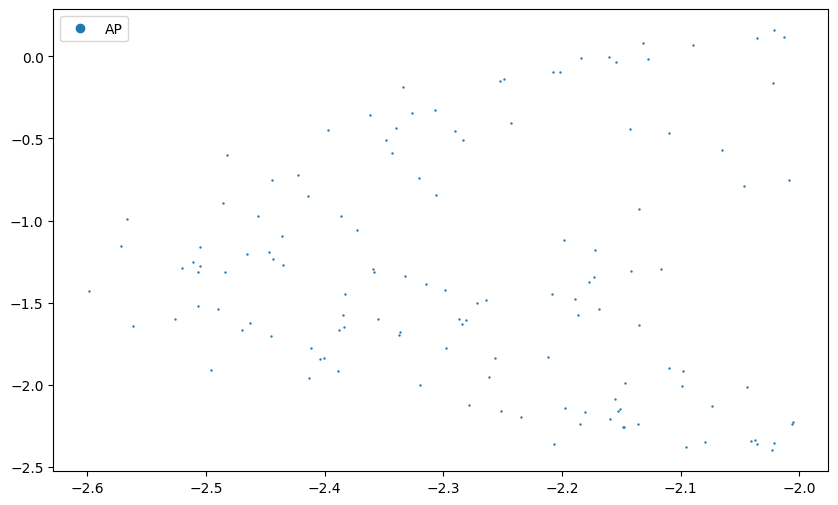

In [44]:
plots.make_tagged_LS_plot(df_AP,
            phones =['AP'],
            alpha = 1, 
            s = 0.5,
            show_global=True,
            add_legend = True)